<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Проверка-на-тесте" data-toc-modified-id="Проверка-на-тесте-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на тесте</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [20]:
import pandas as pd
import re
import catboost
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")
from tqdm import tqdm
from collections import Counter
from sklearn.pipeline import Pipeline
import optuna
import optuna.distributions as dist
RANDOM_STATE = 12345
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/kaggle/input/toxic-comments-csv/toxic_comments (2).csv', index_col=0)

In [3]:
df.head(50)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

В целевом таргете данных явный дисбаланс

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Уберем лишние символы и оставим лишь буквы и цифры

In [6]:
def cleaning_text(text):
    cleaning = ' '.join(re.sub(r"http\S+|www\S+|#\S+|@\S+", " ", text).split())
    cleaning = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
    return ' '.join(cleaning.split())

In [7]:
df['text'] = df['text'].apply(cleaning_text)

In [8]:
df.head(50)

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,Daww He matches this background colour Im seem...,0
2,Hey man Im really not trying to edit war Its j...,0
3,More I cant make any real suggestions on impro...,0
4,You sir are my hero Any chance you remember wh...,0
5,Congratulations from me as well use the tools ...,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


Далее лемматизируем и удалим стоп слова. 

In [9]:
def clean_and_lemmatize(text):
    doc = nlp(text)
    lemmas_and_stop_words = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS]
    cleaned_text = ' '.join(lemmas_and_stop_words)
    return cleaned_text

In [10]:
tqdm.pandas()

In [11]:
df['text'] = df['text'].progress_apply(clean_and_lemmatize)

100%|██████████| 159292/159292 [45:05<00:00, 58.87it/s] 


In [12]:
!/opt/conda/bin/python -m pip install wordcloud 

In [24]:
df['text'] = df['text'].str.lower()
print(df['text'])

0         explanation edit username hardcore metallica f...
1         daww match background colour i m seemingly stu...
2         hey man i m try edit war guy constantly remove...
3         more i real suggestion improvement i wonder se...
4                           sir hero chance remember page s
                                ...                        
159446    second time ask view completely contradict cov...
159447                     ashamed horrible thing talk page
159448    spitzer umm s actual article prostitution ring...
159449      look like actually speedy version delete i look
159450    i think understand i come idea bad right away ...
Name: text, Length: 159292, dtype: object


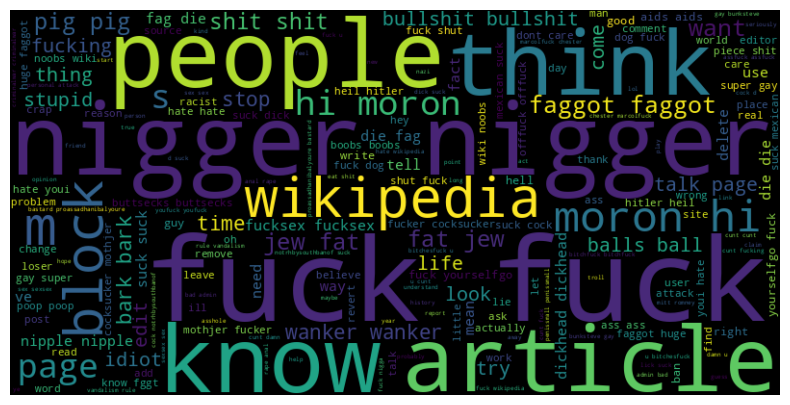

In [25]:
# Создание облака слов для токсичных текстов
toxic_words = ' '.join(df[df['toxic'] == 1]['text']).split()
wordcloud_toxic = WordCloud(width=800, height=400, max_words=200, background_color='black').generate(' '.join(toxic_words))

# Отображение облака слов для токсичных текстов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.show()

## Обучение

### Linear Regression

Разделим выборки

In [26]:
train, test = train_test_split(df, test_size=0.2, random_state= RANDOM_STATE, stratify = df['toxic'])
test, val = train_test_split(test, test_size=0.5, random_state= RANDOM_STATE, stratify = test['toxic'])

In [27]:
X = ['text']
text_features = ['text']
y = ['toxic']

In [28]:
X_train, y_train = train[text_features], train[y].values.ravel()
X_val, y_val = val[text_features], val[y].values.ravel()
X_test, y_test = test[text_features], test[y].values.ravel()

In [29]:
def objective(trial):
    # Определение модели с несколькими гиперпараметрами
    model = LogisticRegression(
        C=trial.suggest_float("C", 1e-5, 1e2),
        penalty=trial.suggest_categorical("penalty", [ 'l2']),
        solver=trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        max_iter=trial.suggest_int("max_iter", 50, 800)
    )
  
    # Определение pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Преобразование текста в TF-IDF признаки
        ('classifier', model)  # Обучение логистической регрессии
    ])

    # Обучение и оценка модели
    pipeline.fit(X_train['text'], y_train)
    y_val_pred = pipeline.predict(X_val['text'])
    f1 = f1_score(y_val, y_val_pred, average='binary')  # Метрика F1 для бинарной классификации

    return f1

# запуск оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Получение лучших гиперпараметров
best_params = study.best_params
print('Best hyperparameters:', best_params)

# Создание финальной модели с лучшими гиперпараметрами
best_model = LogisticRegression(
    C=best_params["C"],
    penalty=best_params["penalty"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"]
)
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('classifier', best_model)  
])

# Обучение финальной модели на всем тренировочном наборе
final_pipeline.fit(X_train['text'], y_train)


[I 2024-01-12 14:47:30,675] A new study created in memory with name: no-name-fc1bcb30-9d18-4ea7-bdd0-ad6583d34682
[I 2024-01-12 14:48:10,815] Trial 0 finished with value: 0.7733598409542743 and parameters: {'C': 81.13400277873694, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 516}. Best is trial 0 with value: 0.7733598409542743.
[I 2024-01-12 14:48:21,609] Trial 1 finished with value: 0.7833503923575571 and parameters: {'C': 7.221903554245897, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 416}. Best is trial 1 with value: 0.7833503923575571.
[I 2024-01-12 14:48:41,500] Trial 2 finished with value: 0.7799535346830401 and parameters: {'C': 41.59064086139884, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 652}. Best is trial 1 with value: 0.7833503923575571.
[I 2024-01-12 14:48:58,134] Trial 3 finished with value: 0.7798195790177079 and parameters: {'C': 31.11440973346116, 'penalty': 'l2', 'solver': 'sag', 'max_iter': 224}. Best is trial 1 with value: 0.7833503923575571.
[I 20

Best hyperparameters: {'C': 8.633201292970412, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 513}


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(C=8.633201292970412, max_iter=513,
                                    solver='liblinear'))])

In [53]:
y_val_pred = final_pipeline.predict(X_val['text'])
f1_lr = f1_score(y_val, y_val_pred, average='binary')
f1_lr

0.7847151142954623

In [31]:
# Assuming val['toxic'] contains the true binary labels and val['y_score'] contains the model's predicted probabilities
def calculate_optimal_threshold(true_labels, predicted_probabilities):
    # Calculate F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)
    f1_scores = []
    for threshold in thresholds:
        predicted_labels = (predicted_probabilities >= threshold).astype(int)
        f1 = f1_score(true_labels, predicted_labels)
        f1_scores.append(f1)

    # Find threshold with the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_index]
    max_f1_score = f1_scores[max_f1_index]

    return optimal_threshold, max_f1_score

### CatBoost

CatBoost умеет работать с текстовыми фичами, поэтому доп. преобразований проводить не надо

In [37]:
def catboost_objective(trial):
    # Определение параметров модели с несколькими гиперпараметрами
    params = {'eval_metric': 'AUC',
        'iterations': trial.suggest_int("iterations", 500, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'text_features': text_features,
        'verbose': 100
    }

    # Определение pipeline
    pipeline = Pipeline([
        ('classifier', CatBoostClassifier(**params))  # Обучение CatBoost
    ])

    # Обучение и оценка модели
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='binary')  # Метрика F1 для бинарной классификации

    return f1

# Создание и запуск оптимизации
catboost_study = optuna.create_study(direction="maximize")
catboost_study.optimize(catboost_objective, n_trials=25)

# Получение лучших гиперпараметров
catboost_best_params = catboost_study.best_params
print('Best hyperparameters for CatBoost:', catboost_best_params)

# Создание финальной модели с лучшими гиперпараметрами
catboost_best_model = CatBoostClassifier(**catboost_best_params, verbose= 100,
          task_type= 'GPU',  text_features= text_features,'eval_metric': 'AUC')
catboost_final_pipeline = Pipeline([
    ('classifier', catboost_best_model)  # Обучение CatBoost
])

# Обучение финальной модели на всем тренировочном наборе
catboost_final_pipeline.fit(X_train, y_train)

# Оценка финальной модели на тестовом наборе
y_val_pred_catboost = catboost_final_pipeline.predict(X_val)
final_f1_catboost = f1_score(y_val, y_val_pred_catboost, average='binary')
print(f'F1 Score on test set (CatBoost): {final_f1_catboost}')

[I 2024-01-12 16:46:29,737] A new study created in memory with name: no-name-abad4155-4872-4542-b1a4-d1aabbe45fa3


0:	learn: 0.6656730	total: 112ms	remaining: 1m 19s
100:	learn: 0.1624332	total: 9.52s	remaining: 57.3s
200:	learn: 0.1485165	total: 18.9s	remaining: 47.8s
300:	learn: 0.1424564	total: 28.4s	remaining: 38.4s
400:	learn: 0.1383216	total: 37.7s	remaining: 28.9s
500:	learn: 0.1347958	total: 47.2s	remaining: 19.6s
600:	learn: 0.1316343	total: 56.6s	remaining: 10.2s
700:	learn: 0.1290103	total: 1m 5s	remaining: 752ms
708:	learn: 0.1288322	total: 1m 6s	remaining: 0us


[I 2024-01-12 16:47:42,196] Trial 0 finished with value: 0.7537154989384289 and parameters: {'iterations': 709, 'learning_rate': 0.0184278621656654, 'depth': 10, 'l2_leaf_reg': 0.029012007708096928, 'bootstrap_type': 'Bayesian', 'random_strength': 1.406403054129803e-06, 'bagging_temperature': 6.664228129428025, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6767714	total: 14.2ms	remaining: 12.9s
100:	learn: 0.1936762	total: 1.84s	remaining: 14.7s
200:	learn: 0.1593775	total: 3.57s	remaining: 12.6s
300:	learn: 0.1520727	total: 5.31s	remaining: 10.7s
400:	learn: 0.1482941	total: 6.97s	remaining: 8.81s
500:	learn: 0.1458872	total: 8.68s	remaining: 7.05s
600:	learn: 0.1438444	total: 10.4s	remaining: 5.32s
700:	learn: 0.1420443	total: 12s	remaining: 3.56s
800:	learn: 0.1406195	total: 13.7s	remaining: 1.83s
900:	learn: 0.1393919	total: 15.5s	remaining: 120ms
907:	learn: 0.1393144	total: 15.6s	remaining: 0us


[I 2024-01-12 16:48:03,306] Trial 1 finished with value: 0.7499118165784833 and parameters: {'iterations': 908, 'learning_rate': 0.010725693067121693, 'depth': 4, 'l2_leaf_reg': 3.2067223325320057e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 2.863440763072341e-05, 'bagging_temperature': 1.8749969835509472, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6769189	total: 67.7ms	remaining: 44.7s
100:	learn: 0.1976342	total: 5.62s	remaining: 31.2s
200:	learn: 0.1597910	total: 11.2s	remaining: 25.6s
300:	learn: 0.1507710	total: 17s	remaining: 20.3s
400:	learn: 0.1465911	total: 22.6s	remaining: 14.6s
500:	learn: 0.1434052	total: 28.1s	remaining: 8.98s
600:	learn: 0.1408428	total: 33.7s	remaining: 3.36s
660:	learn: 0.1395941	total: 37s	remaining: 0us


[I 2024-01-12 16:48:46,218] Trial 2 finished with value: 0.745679012345679 and parameters: {'iterations': 661, 'learning_rate': 0.009856605390053034, 'depth': 9, 'l2_leaf_reg': 9.669478942486824e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.05281146496595148, 'bagging_temperature': 4.597895023877468, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6728240	total: 79.2ms	remaining: 1m 6s
100:	learn: 0.1810780	total: 5.7s	remaining: 41.8s
200:	learn: 0.1599758	total: 11.2s	remaining: 35.7s
300:	learn: 0.1530016	total: 16.8s	remaining: 30.1s
400:	learn: 0.1484242	total: 22.3s	remaining: 24.5s
500:	learn: 0.1447074	total: 27.9s	remaining: 18.9s
600:	learn: 0.1415409	total: 33.5s	remaining: 13.4s
700:	learn: 0.1386089	total: 39.1s	remaining: 7.81s
800:	learn: 0.1359717	total: 44.6s	remaining: 2.23s
840:	learn: 0.1350692	total: 46.9s	remaining: 0us


[I 2024-01-12 16:49:38,982] Trial 3 finished with value: 0.7474318101310663 and parameters: {'iterations': 841, 'learning_rate': 0.014055868509488183, 'depth': 9, 'l2_leaf_reg': 5.983961863515435e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.6497484384572527, 'bagging_temperature': 9.819303841630525, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6913191	total: 53.7ms	remaining: 35.7s
100:	learn: 0.5368417	total: 3.85s	remaining: 21.5s
200:	learn: 0.4301391	total: 7.61s	remaining: 17.6s
300:	learn: 0.3558392	total: 11.5s	remaining: 13.9s
400:	learn: 0.3045750	total: 15.3s	remaining: 10.1s
500:	learn: 0.2682622	total: 19s	remaining: 6.26s
600:	learn: 0.2421770	total: 22.8s	remaining: 2.47s
665:	learn: 0.2290008	total: 25.2s	remaining: 0us


[I 2024-01-12 16:50:09,796] Trial 4 finished with value: 0.7183762232693006 and parameters: {'iterations': 666, 'learning_rate': 0.001226351528197156, 'depth': 8, 'l2_leaf_reg': 0.0021043973633442397, 'bootstrap_type': 'Bayesian', 'random_strength': 0.6798087267263443, 'bagging_temperature': 6.524396399374314, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6801346	total: 14.6ms	remaining: 11.2s
100:	learn: 0.2267070	total: 1.84s	remaining: 12.1s
200:	learn: 0.1794572	total: 3.69s	remaining: 10.4s
300:	learn: 0.1683449	total: 5.51s	remaining: 8.57s
400:	learn: 0.1638699	total: 7.44s	remaining: 6.83s
500:	learn: 0.1610569	total: 9.3s	remaining: 4.97s
600:	learn: 0.1589566	total: 11.1s	remaining: 3.11s
700:	learn: 0.1571735	total: 13.1s	remaining: 1.27s
768:	learn: 0.1557955	total: 14.4s	remaining: 0us


[I 2024-01-12 16:50:29,793] Trial 5 finished with value: 0.7326732673267328 and parameters: {'iterations': 769, 'learning_rate': 0.008856138023097525, 'depth': 5, 'l2_leaf_reg': 0.12107713676326337, 'bootstrap_type': 'Bayesian', 'random_strength': 0.009916427083202742, 'bagging_temperature': 6.458626118028844, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6891640	total: 103ms	remaining: 1m 34s
100:	learn: 0.4052642	total: 9.51s	remaining: 1m 17s
200:	learn: 0.2791907	total: 18.9s	remaining: 1m 8s
300:	learn: 0.2208670	total: 28.4s	remaining: 58.8s
400:	learn: 0.1921814	total: 37.8s	remaining: 49.2s
500:	learn: 0.1770979	total: 47.2s	remaining: 39.8s
600:	learn: 0.1685231	total: 56.7s	remaining: 30.4s
700:	learn: 0.1632403	total: 1m 5s	remaining: 20.9s
800:	learn: 0.1593634	total: 1m 15s	remaining: 11.5s
900:	learn: 0.1565359	total: 1m 24s	remaining: 2.07s
922:	learn: 0.1560538	total: 1m 27s	remaining: 0us


[I 2024-01-12 16:52:02,660] Trial 6 finished with value: 0.7334283677833215 and parameters: {'iterations': 923, 'learning_rate': 0.002735568306170248, 'depth': 10, 'l2_leaf_reg': 7.317361186878127e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00011888348391323143, 'bagging_temperature': 7.124837144324603, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6778653	total: 19.6ms	remaining: 12s
100:	learn: 0.2044760	total: 2.16s	remaining: 10.9s
200:	learn: 0.1729782	total: 4.24s	remaining: 8.67s
300:	learn: 0.1654778	total: 6.39s	remaining: 6.6s
400:	learn: 0.1616883	total: 8.49s	remaining: 4.47s
500:	learn: 0.1587762	total: 10.7s	remaining: 2.36s
600:	learn: 0.1560870	total: 12.7s	remaining: 233ms
611:	learn: 0.1557736	total: 12.9s	remaining: 0us


[I 2024-01-12 16:52:21,240] Trial 7 finished with value: 0.7324142806645458 and parameters: {'iterations': 612, 'learning_rate': 0.011563167955534732, 'depth': 6, 'l2_leaf_reg': 7.229279339514956e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00010184832296408265, 'bagging_temperature': 9.523848933909413, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.7537154989384289.


0:	learn: 0.6046488	total: 50.7ms	remaining: 38.7s
100:	learn: 0.1504227	total: 3.8s	remaining: 24.9s
200:	learn: 0.1420322	total: 7.64s	remaining: 21.4s
300:	learn: 0.1374352	total: 11.4s	remaining: 17.5s
400:	learn: 0.1343214	total: 15.1s	remaining: 13.7s
500:	learn: 0.1316803	total: 18.9s	remaining: 9.91s
600:	learn: 0.1293050	total: 22.6s	remaining: 6.13s
700:	learn: 0.1273150	total: 26.3s	remaining: 2.36s
763:	learn: 0.1263988	total: 28.7s	remaining: 0us


[I 2024-01-12 16:52:55,597] Trial 8 finished with value: 0.7576289021396002 and parameters: {'iterations': 764, 'learning_rate': 0.06327622990972105, 'depth': 8, 'l2_leaf_reg': 70.50089497068879, 'bootstrap_type': 'Bayesian', 'random_strength': 3.266464242459714e-05, 'bagging_temperature': 7.966680350850904, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 8 with value: 0.7576289021396002.


0:	learn: 0.6868444	total: 54.5ms	remaining: 27.6s
100:	learn: 0.3258408	total: 3.92s	remaining: 15.7s
200:	learn: 0.2213052	total: 7.74s	remaining: 11.8s
300:	learn: 0.1849414	total: 11.5s	remaining: 7.88s
400:	learn: 0.1705939	total: 15.3s	remaining: 4.04s
500:	learn: 0.1634397	total: 19s	remaining: 227ms
506:	learn: 0.1631236	total: 19.2s	remaining: 0us


[I 2024-01-12 16:53:20,393] Trial 9 finished with value: 0.7281867145421904 and parameters: {'iterations': 507, 'learning_rate': 0.004250167409298242, 'depth': 8, 'l2_leaf_reg': 0.0010531727005963275, 'bootstrap_type': 'Bayesian', 'random_strength': 5.412843779247202e-08, 'bagging_temperature': 5.9678014085133535, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 8 with value: 0.7576289021396002.


0:	learn: 0.5599581	total: 24.7ms	remaining: 19.8s
100:	learn: 0.1304867	total: 2.82s	remaining: 19.6s
200:	learn: 0.1232849	total: 5.65s	remaining: 16.9s
300:	learn: 0.1196002	total: 8.49s	remaining: 14.1s
400:	learn: 0.1174772	total: 11.4s	remaining: 11.4s
500:	learn: 0.1156964	total: 14.1s	remaining: 8.48s
600:	learn: 0.1141431	total: 16.9s	remaining: 5.64s
700:	learn: 0.1131157	total: 19.6s	remaining: 2.83s
800:	learn: 0.1118163	total: 22.4s	remaining: 27.9ms
801:	learn: 0.1118104	total: 22.4s	remaining: 0us


[I 2024-01-12 16:53:48,383] Trial 10 finished with value: 0.769496204278813 and parameters: {'iterations': 802, 'learning_rate': 0.09028266467030953, 'depth': 7, 'l2_leaf_reg': 35.487586321120226, 'bootstrap_type': 'Bayesian', 'random_strength': 4.380140374482195e-08, 'bagging_temperature': 0.2909043360886967, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 10 with value: 0.769496204278813.


0:	learn: 0.5563605	total: 41.5ms	remaining: 33.1s
100:	learn: 0.1316540	total: 2.81s	remaining: 19.4s
200:	learn: 0.1246640	total: 5.53s	remaining: 16.4s
300:	learn: 0.1211316	total: 8.29s	remaining: 13.7s
400:	learn: 0.1187587	total: 11.1s	remaining: 10.9s
500:	learn: 0.1169934	total: 13.8s	remaining: 8.15s
600:	learn: 0.1155556	total: 16.5s	remaining: 5.42s
700:	learn: 0.1145102	total: 19.2s	remaining: 2.65s
797:	learn: 0.1135750	total: 21.8s	remaining: 0us


[I 2024-01-12 16:54:15,720] Trial 11 finished with value: 0.772508591065292 and parameters: {'iterations': 798, 'learning_rate': 0.09289760943300962, 'depth': 7, 'l2_leaf_reg': 80.19687870369397, 'bootstrap_type': 'Bayesian', 'random_strength': 1.0434487935807952e-08, 'bagging_temperature': 0.1973385192669744, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.5708446	total: 17.6ms	remaining: 14.6s
100:	learn: 0.1344039	total: 2.16s	remaining: 15.6s
200:	learn: 0.1268447	total: 4.32s	remaining: 13.5s
300:	learn: 0.1231316	total: 6.49s	remaining: 11.4s
400:	learn: 0.1208313	total: 8.65s	remaining: 9.25s
500:	learn: 0.1194230	total: 10.8s	remaining: 7.09s
600:	learn: 0.1180959	total: 12.9s	remaining: 4.92s
700:	learn: 0.1171442	total: 15.1s	remaining: 2.77s
800:	learn: 0.1162581	total: 17.2s	remaining: 621ms
829:	learn: 0.1160399	total: 17.8s	remaining: 0us


[I 2024-01-12 16:54:38,946] Trial 12 finished with value: 0.769177608845888 and parameters: {'iterations': 830, 'learning_rate': 0.08315457396727562, 'depth': 6, 'l2_leaf_reg': 59.625129779785745, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3337596634130125e-08, 'bagging_temperature': 0.14306419602906043, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6332461	total: 25ms	remaining: 24.8s
100:	learn: 0.1403436	total: 2.75s	remaining: 24.4s
200:	learn: 0.1308115	total: 5.49s	remaining: 21.7s
300:	learn: 0.1253728	total: 8.27s	remaining: 19.1s
400:	learn: 0.1215427	total: 11s	remaining: 16.3s
500:	learn: 0.1187398	total: 13.7s	remaining: 13.5s
600:	learn: 0.1163663	total: 16.4s	remaining: 10.8s
700:	learn: 0.1142858	total: 19.1s	remaining: 8.02s
800:	learn: 0.1124444	total: 21.8s	remaining: 5.29s
900:	learn: 0.1107368	total: 24.6s	remaining: 2.56s
994:	learn: 0.1092662	total: 27.2s	remaining: 0us


[I 2024-01-12 16:55:12,219] Trial 13 finished with value: 0.7679003804911795 and parameters: {'iterations': 995, 'learning_rate': 0.03797187979520836, 'depth': 7, 'l2_leaf_reg': 0.954907446655836, 'bootstrap_type': 'Bayesian', 'random_strength': 6.295161900676925e-07, 'bagging_temperature': 0.1570466390065822, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6430830	total: 19ms	remaining: 15.6s
100:	learn: 0.1493002	total: 2.17s	remaining: 15.5s
200:	learn: 0.1416664	total: 4.32s	remaining: 13.3s
300:	learn: 0.1375591	total: 6.44s	remaining: 11.2s
400:	learn: 0.1347259	total: 8.54s	remaining: 8.97s
500:	learn: 0.1325668	total: 10.7s	remaining: 6.83s
600:	learn: 0.1306955	total: 12.8s	remaining: 4.71s
700:	learn: 0.1290542	total: 14.9s	remaining: 2.58s
800:	learn: 0.1277071	total: 17s	remaining: 446ms
821:	learn: 0.1274093	total: 17.5s	remaining: 0us


[I 2024-01-12 16:55:35,289] Trial 14 finished with value: 0.7556022408963585 and parameters: {'iterations': 822, 'learning_rate': 0.03292331518859015, 'depth': 6, 'l2_leaf_reg': 2.2036634360043226, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3088742150413247e-08, 'bagging_temperature': 2.814136421531023, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6150250	total: 24ms	remaining: 21.3s
100:	learn: 0.1388795	total: 2.84s	remaining: 22.1s
200:	learn: 0.1317743	total: 5.56s	remaining: 19s
300:	learn: 0.1277492	total: 8.29s	remaining: 16.1s
400:	learn: 0.1250251	total: 11s	remaining: 13.3s
500:	learn: 0.1228998	total: 13.7s	remaining: 10.6s
600:	learn: 0.1210628	total: 16.5s	remaining: 7.84s
700:	learn: 0.1194060	total: 19.2s	remaining: 5.08s
800:	learn: 0.1178651	total: 21.8s	remaining: 2.34s
886:	learn: 0.1167142	total: 24.2s	remaining: 0us


[I 2024-01-12 16:56:05,220] Trial 15 finished with value: 0.7614424410540914 and parameters: {'iterations': 887, 'learning_rate': 0.05141207719951366, 'depth': 7, 'l2_leaf_reg': 4.1368365518642705, 'bootstrap_type': 'Bayesian', 'random_strength': 5.906313114569627e-07, 'bagging_temperature': 1.9996717041585939, 'od_type': 'Iter', 'od_wait': 18}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.5538466	total: 14.8ms	remaining: 14.7s
100:	learn: 0.1450719	total: 1.81s	remaining: 16s
200:	learn: 0.1383596	total: 3.7s	remaining: 14.5s
300:	learn: 0.1330390	total: 5.7s	remaining: 13s
400:	learn: 0.1295381	total: 7.61s	remaining: 11.2s
500:	learn: 0.1263663	total: 9.39s	remaining: 9.15s
600:	learn: 0.1238038	total: 11.2s	remaining: 7.24s
700:	learn: 0.1216017	total: 13.1s	remaining: 5.36s
800:	learn: 0.1196104	total: 14.9s	remaining: 3.49s
900:	learn: 0.1175105	total: 16.7s	remaining: 1.63s
988:	learn: 0.1158739	total: 18.3s	remaining: 0us


[I 2024-01-12 16:56:29,255] Trial 16 finished with value: 0.7627711686494052 and parameters: {'iterations': 989, 'learning_rate': 0.09728851257520611, 'depth': 5, 'l2_leaf_reg': 4.0660298095036726e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 3.968375359367747e-06, 'bagging_temperature': 4.3953716886748335, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6528348	total: 23.3ms	remaining: 16.9s
100:	learn: 0.1470941	total: 2.73s	remaining: 17s
200:	learn: 0.1373335	total: 5.44s	remaining: 14.3s
300:	learn: 0.1323559	total: 8.13s	remaining: 11.6s
400:	learn: 0.1292190	total: 10.8s	remaining: 8.87s
500:	learn: 0.1268251	total: 13.6s	remaining: 6.2s
600:	learn: 0.1250065	total: 16.3s	remaining: 3.48s
700:	learn: 0.1236641	total: 19s	remaining: 758ms
728:	learn: 0.1232951	total: 19.7s	remaining: 0us


[I 2024-01-12 16:56:54,375] Trial 17 finished with value: 0.763724808895066 and parameters: {'iterations': 729, 'learning_rate': 0.025346225402162765, 'depth': 7, 'l2_leaf_reg': 7.515440203029557, 'bootstrap_type': 'Bayesian', 'random_strength': 1.0162288696124748e-07, 'bagging_temperature': 1.0295345171931056, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6198807	total: 14.3ms	remaining: 8.53s
100:	learn: 0.1481984	total: 1.74s	remaining: 8.55s
200:	learn: 0.1410874	total: 3.51s	remaining: 6.92s
300:	learn: 0.1368297	total: 5.37s	remaining: 5.28s
400:	learn: 0.1339546	total: 7.17s	remaining: 3.5s
500:	learn: 0.1315175	total: 8.99s	remaining: 1.72s
596:	learn: 0.1293884	total: 10.7s	remaining: 0us


[I 2024-01-12 16:57:10,510] Trial 18 finished with value: 0.7519434628975264 and parameters: {'iterations': 597, 'learning_rate': 0.04908285180454821, 'depth': 5, 'l2_leaf_reg': 0.03923050225151213, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0033261395401499427, 'bagging_temperature': 3.1837584077801973, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.5460171	total: 69.6ms	remaining: 55.2s
100:	learn: 0.1318402	total: 5.66s	remaining: 38.8s
200:	learn: 0.1223407	total: 11.2s	remaining: 33.2s
300:	learn: 0.1162532	total: 16.7s	remaining: 27.4s
400:	learn: 0.1117294	total: 22.3s	remaining: 21.9s
500:	learn: 0.1079444	total: 27.8s	remaining: 16.3s
600:	learn: 0.1043987	total: 33.4s	remaining: 10.7s
700:	learn: 0.1013966	total: 39s	remaining: 5.18s
793:	learn: 0.0987123	total: 44.1s	remaining: 0us


[I 2024-01-12 16:58:00,286] Trial 19 finished with value: 0.7694974003466204 and parameters: {'iterations': 794, 'learning_rate': 0.09685829295483972, 'depth': 9, 'l2_leaf_reg': 0.2635321475641664, 'bootstrap_type': 'Bayesian', 'random_strength': 1.667299976301658e-07, 'bagging_temperature': 3.362028856741193, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.6839843	total: 70.2ms	remaining: 1m 1s
100:	learn: 0.2706991	total: 5.66s	remaining: 43.1s
200:	learn: 0.1880700	total: 11.3s	remaining: 37.5s
300:	learn: 0.1638845	total: 16.9s	remaining: 31.9s
400:	learn: 0.1549168	total: 22.4s	remaining: 26.3s
500:	learn: 0.1503396	total: 28s	remaining: 20.6s
600:	learn: 0.1473537	total: 33.6s	remaining: 15s
700:	learn: 0.1453119	total: 39.3s	remaining: 9.47s
800:	learn: 0.1434572	total: 44.9s	remaining: 3.87s
869:	learn: 0.1423631	total: 48.9s	remaining: 0us


[I 2024-01-12 16:58:54,972] Trial 20 finished with value: 0.7447787610619468 and parameters: {'iterations': 870, 'learning_rate': 0.0054826143939462595, 'depth': 9, 'l2_leaf_reg': 0.30641872245216195, 'bootstrap_type': 'Bayesian', 'random_strength': 7.714162088928403e-06, 'bagging_temperature': 3.892302763647626, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 11 with value: 0.772508591065292.


0:	learn: 0.5477334	total: 53.6ms	remaining: 42.5s
100:	learn: 0.1304841	total: 3.83s	remaining: 26.3s
200:	learn: 0.1242456	total: 7.58s	remaining: 22.4s
300:	learn: 0.1209808	total: 11.3s	remaining: 18.5s
400:	learn: 0.1189286	total: 15.1s	remaining: 14.8s
500:	learn: 0.1171270	total: 18.8s	remaining: 11s
600:	learn: 0.1158124	total: 22.5s	remaining: 7.23s
700:	learn: 0.1147986	total: 26.4s	remaining: 3.5s
793:	learn: 0.1137906	total: 29.8s	remaining: 0us


[I 2024-01-12 16:59:30,523] Trial 21 finished with value: 0.7729302645139128 and parameters: {'iterations': 794, 'learning_rate': 0.0985356765968238, 'depth': 8, 'l2_leaf_reg': 95.73151042573794, 'bootstrap_type': 'Bayesian', 'random_strength': 1.9828098788155632e-07, 'bagging_temperature': 0.9839101481470829, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 21 with value: 0.7729302645139128.


0:	learn: 0.6038878	total: 52ms	remaining: 40.3s
100:	learn: 0.1330044	total: 3.81s	remaining: 25.5s
200:	learn: 0.1243933	total: 7.53s	remaining: 21.6s
300:	learn: 0.1189480	total: 11.3s	remaining: 17.9s
400:	learn: 0.1148991	total: 15s	remaining: 14.1s
500:	learn: 0.1111002	total: 18.8s	remaining: 10.4s
600:	learn: 0.1078907	total: 22.6s	remaining: 6.61s
700:	learn: 0.1051191	total: 26.3s	remaining: 2.85s
776:	learn: 0.1033672	total: 29.2s	remaining: 0us


[I 2024-01-12 17:00:05,537] Trial 22 finished with value: 0.7679003804911795 and parameters: {'iterations': 777, 'learning_rate': 0.057198432002404605, 'depth': 8, 'l2_leaf_reg': 0.00780673233879103, 'bootstrap_type': 'Bayesian', 'random_strength': 1.808838703204606e-07, 'bagging_temperature': 1.6980640297347285, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 21 with value: 0.7729302645139128.


0:	learn: 0.6525529	total: 72.4ms	remaining: 50.7s
100:	learn: 0.1435240	total: 5.78s	remaining: 34.4s
200:	learn: 0.1334828	total: 11.4s	remaining: 28.4s
300:	learn: 0.1286588	total: 17.1s	remaining: 22.7s
400:	learn: 0.1256669	total: 22.7s	remaining: 17s
500:	learn: 0.1234501	total: 28.3s	remaining: 11.4s
600:	learn: 0.1216369	total: 33.9s	remaining: 5.69s
700:	learn: 0.1202533	total: 39.4s	remaining: 56.2ms
701:	learn: 0.1202392	total: 39.5s	remaining: 0us


[I 2024-01-12 17:00:50,582] Trial 23 finished with value: 0.7675148135238758 and parameters: {'iterations': 702, 'learning_rate': 0.025045949126261024, 'depth': 9, 'l2_leaf_reg': 9.5249353882382, 'bootstrap_type': 'Bayesian', 'random_strength': 2.2269543556306548e-07, 'bagging_temperature': 1.1695843249064188, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 21 with value: 0.7729302645139128.


0:	learn: 0.5824170	total: 53.4ms	remaining: 45.5s
100:	learn: 0.1360607	total: 3.85s	remaining: 28.6s
200:	learn: 0.1281040	total: 7.54s	remaining: 24.4s
300:	learn: 0.1232375	total: 11.2s	remaining: 20.6s
400:	learn: 0.1195989	total: 14.9s	remaining: 16.8s
500:	learn: 0.1164347	total: 18.7s	remaining: 13.1s
600:	learn: 0.1137973	total: 22.4s	remaining: 9.35s
700:	learn: 0.1111777	total: 26.1s	remaining: 5.62s
800:	learn: 0.1089574	total: 29.8s	remaining: 1.9s
851:	learn: 0.1078738	total: 31.7s	remaining: 0us


[I 2024-01-12 17:01:28,047] Trial 24 finished with value: 0.7677889621659145 and parameters: {'iterations': 852, 'learning_rate': 0.07211383809951134, 'depth': 8, 'l2_leaf_reg': 0.5231447085862738, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1776473215279886e-08, 'bagging_temperature': 2.95278518176056, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 21 with value: 0.7729302645139128.


Best hyperparameters for CatBoost: {'iterations': 794, 'learning_rate': 0.0985356765968238, 'depth': 8, 'l2_leaf_reg': 95.73151042573794, 'bootstrap_type': 'Bayesian', 'random_strength': 1.9828098788155632e-07, 'bagging_temperature': 0.9839101481470829, 'od_type': 'Iter', 'od_wait': 34}
0:	learn: 0.5477334	total: 51.5ms	remaining: 40.8s
100:	learn: 0.1304841	total: 3.83s	remaining: 26.3s
200:	learn: 0.1242457	total: 7.56s	remaining: 22.3s
300:	learn: 0.1209808	total: 11.3s	remaining: 18.5s
400:	learn: 0.1189286	total: 15s	remaining: 14.7s
500:	learn: 0.1171270	total: 18.8s	remaining: 11s
600:	learn: 0.1158124	total: 22.5s	remaining: 7.21s
700:	learn: 0.1147986	total: 26.2s	remaining: 3.47s
793:	learn: 0.1137906	total: 29.7s	remaining: 0us
F1 Score on test set (CatBoost): 0.7729302645139128


In [41]:
params = {'eval_metric': 'AUC',
          'learning_rate': 0.15,
          'text_features':text_features,
          'task_type': 'GPU',
          'verbose': 100}

In [42]:
model = CatBoostClassifier(**params)

In [43]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8984511	best: 0.8984511 (0)	total: 13s	remaining: 3h 36m 7s
100:	test: 0.9622275	best: 0.9622275 (100)	total: 15.3s	remaining: 2m 15s
200:	test: 0.9646468	best: 0.9646546 (190)	total: 17.5s	remaining: 1m 9s
300:	test: 0.9656105	best: 0.9656105 (300)	total: 19.9s	remaining: 46.1s
400:	test: 0.9659535	best: 0.9659571 (395)	total: 22.1s	remaining: 33s
500:	test: 0.9666591	best: 0.9666591 (500)	total: 24.3s	remaining: 24.2s
600:	test: 0.9670749	best: 0.9671032 (590)	total: 26.5s	remaining: 17.6s
700:	test: 0.9673591	best: 0.9673591 (700)	total: 28.8s	remaining: 12.3s
800:	test: 0.9677656	best: 0.9677656 (800)	total: 31.3s	remaining: 7.77s
900:	test: 0.9676415	best: 0.9678651 (840)	total: 33.5s	remaining: 3.68s
999:	test: 0.9677800	best: 0.9678651 (840)	total: 35.7s	remaining: 0us
bestTest = 0.9678651392
bestIteration = 840
Shrink model to first 841 iterations.


In [51]:
threshhold, f1_score_cat, = calculate_optimal_threshold(y_val, model.predict_proba(val[X])[:,1])
f1_score_cat, threshhold

(0.7883843064565956, 0.3)

Типичная ситуация для кетбуста, он из коробки работает лучше, чем при попытках оптимизировать его гиперпараметры. Будем использовать дефолтные настройки

In [55]:
scores = {'CatBoost': f1_score_cat, 'LR': f1_lr}

df_scores = pd.DataFrame(list(scores.items()), columns=['Model', 'Score']).set_index('Model')

print(df_scores)

             Score
Model             
CatBoost  0.788384
LR        0.784715


### Проверка на тесте

In [56]:
params = {'eval_metric': 'AUC',
          'iterations': model.best_iteration_,
          'learning_rate': model.learning_rate_,
          'text_features':text_features,
          'verbose': 100}

In [57]:
model = CatBoostClassifier(**params)

In [58]:
train_val = pd.concat([train, val])

In [59]:
model.fit(train_val[X],train_val[y])

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.3ms	remaining: 17s
100:	total: 2.26s	remaining: 16.5s
200:	total: 4.65s	remaining: 14.8s
300:	total: 6.9s	remaining: 12.4s
400:	total: 9.09s	remaining: 9.95s
500:	total: 11.3s	remaining: 7.63s
600:	total: 13.4s	remaining: 5.35s
700:	total: 15.7s	remaining: 3.12s
800:	total: 17.9s	remaining: 872ms
839:	total: 18.8s	remaining: 0us


In [60]:
test['y_score'] = model.predict_proba(test[X])[:,1]
catboost_score = f1_score(test['toxic'], test['y_score'] >= optimal_threshold)

In [62]:
print('Final result f1 score for catboost model on test:',catboost_score)

Final result f1 score for catboost model on test: 0.7947761194029851


## Выводы

Обе модели успешно справились с назначенным порогом в 0.75.<br>
Однако, catboost не требует создания фичей на основе текстовых данных, что является огромнейшим плюсом.<br>
подбор гиперпараметров не дал ожидаемого прироста для кетбуста, а вот логистическая регрессия слегка выросла в скоринге f1 меры. <br>
